In [1]:
import os,subprocess
workdir='/mnt/Data1/ribli/splicing_code/modelling/'
subprocess.call(['mkdir',workdir])
os.chdir(workdir)

#theano gpu
os.environ['THEANO_FLAGS']='device=gpu'

#import sys
#sys.path.append('../my_modules')
#from loading_utils import read_my_data

import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('ggplot')
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
import gc

def read_my_data(fname,**kwargs):
    """Load my data from file into np.arrays.
    
    I had to use garbage collector, because pandas read_csv leaves garbage around.
    """
    
    #load data
    print "Loading data... "
    x=pd.read_csv(fname,sep='\t',header=None)
    
    # for some reason not everything is cleaned up
    #when using the pandas read_csv
    gc.collect()
    
    #probe_id=x[0]
    #y=x.iloc[:,-1].values.astype(np.int8)
    #x=x.iloc[:,1:-1].values.astype(np.int8)
    #return probe_id,x,y
    
    return x.iloc[:,:-1].values.astype(np.int32),x.iloc[:,-1].values.astype(np.float64)

In [10]:
train_x,train_y = read_my_data(fname='../prepare_data/naive_feat_vect_200.csv')
print train_x.shape

txn_x,txn_y = read_my_data(fname='../prepare_data/txn_feat_vect_200.csv')
print txn_x.shape

Loading data... 
(10097, 1600)
Loading data... 
(10097, 1600)


In [26]:
#make it image like
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
train_x=lb.fit_transform(np.concatenate([train_x.flatten()])).reshape((-1,1,1600,4))
print train_x.shape

full_x=np.concatenate([train_x,txn_x.reshape(-1,1,1600,1)/1000.0],axis=3)
print full_x.shape

(10097, 1, 1600, 4)
(10097, 1, 1600, 5)


In [27]:
#make target classes
train_y=(0.5*(np.sign(train_y-0.5)+1)).astype(np.int8)

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D,MaxPooling2D
from keras.regularizers import l2

im_size=5

input_dim=full_x.shape[2]
activation='relu'
loss='binary_crossentropy'
optimizer='adam'
init='glorot_normal'
pool_size=(64,1)
window_size=40


model = Sequential()

#Convolution layer
model.add(Convolution2D(100,window_size,im_size, border_mode='valid',
                        input_shape=(1,input_dim,im_size),W_regularizer=l2(0.01)))
model.add(Activation(activation))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
#model.add(Dropout(0.2))

#final layer
model.add(Dense(1, activation='sigmoid'))

#compile model
model.compile(loss=loss,optimizer=optimizer,class_mode='binary')

In [29]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
def fit_keras_model(model,train_x,train_y,test_x,test_y,validation_split=0.05):
    start=time.time()
    
    #callbacks
    best_model=ModelCheckpoint('best_model',save_best_only=True,verbose=1)
    early_stop=EarlyStopping(patience=5,verbose=1)
    
    #train it
    callb_hist=model.fit(train_x,train_y,nb_epoch = 100,
                         show_accuracy=True,verbose=1,
                        validation_split=validation_split,
                        callbacks=[best_model,early_stop])
    #predict
    model.load_weights('best_model')
    train_pred=model.predict_classes(train_x).ravel()
    test_pred=model.predict_classes(test_x).ravel()
    
    train_pred_pr=model.predict(train_x).ravel()
    test_pred_pr=model.predict(test_x).ravel()

    #check errors
    print 'train accuracy:',list((train_pred==train_y)).count(True)/float(len(train_y))
    print 'test accuracy:',list((test_pred==test_y)).count(True)/float(len(test_y))

    print 'It took:',time.time()-start    
    return train_pred,test_pred,train_pred_pr,test_pred_pr

In [30]:
N_train=8000
N_test=2000

train_pred,test_pred,train_pred_pr,test_pred_pr=fit_keras_model(
    model,full_x[:N_train],train_y[:N_train],
    full_x[N_train:N_train+N_test],train_y[N_train:N_train+N_test],
    validation_split=0.2)

Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 11s - loss: 1.8024 - acc: 0.5830 - val_loss: 0.7159 - val_acc: 0.4863
Epoch 00000: val_loss improved from inf to 0.71591, saving model to best_model
Epoch 2/100
6400/6400 [==============================] - 11s - loss: 1.3872 - acc: 0.6106 - val_loss: 0.6803 - val_acc: 0.6212
Epoch 00001: val_loss improved from 0.71591 to 0.68026, saving model to best_model
Epoch 3/100
6400/6400 [==============================] - 11s - loss: 1.1249 - acc: 0.6481 - val_loss: 0.6440 - val_acc: 0.6488
Epoch 00002: val_loss improved from 0.68026 to 0.64402, saving model to best_model
Epoch 4/100
6400/6400 [==============================] - 11s - loss: 0.9733 - acc: 0.6564 - val_loss: 0.6366 - val_acc: 0.6550
Epoch 00003: val_loss improved from 0.64402 to 0.63663, saving model to best_model
Epoch 5/100
6400/6400 [==============================] - 11s - loss: 0.8758 - acc: 0.6623 - val_loss: 0.6446 - val_a

### roc auc

In [31]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline

from sklearn import metrics
def plot_roc(y,probs):
    fpr, tpr, thresholds = metrics.roc_curve(y,probs)
    auc=metrics.roc_auc_score(y,probs)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr,tpr,lw=2)
    plt.plot([0,1],[0,1],lw=2)
    plt.xlim(-0.01,1.01)
    plt.ylim(-0.01,1.01)
    plt.xlabel('FP rate')
    plt.ylabel('TP rate')
    print 'auc:',auc

auc: 0.731162083739


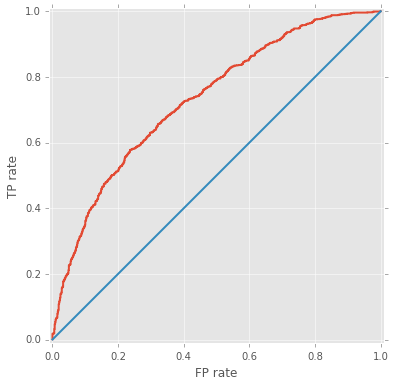

In [32]:
plot_roc(train_y[N_train:N_train+N_test],test_pred_pr)

Loading data... 


(-0.05, 1.05)

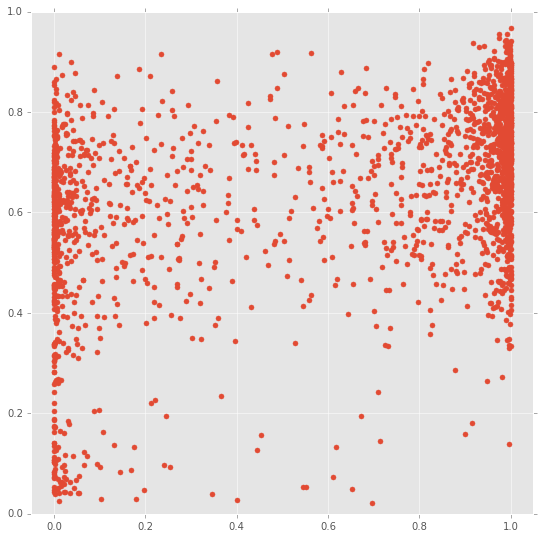

In [33]:
_,orig_train_y = read_my_data(fname='../prepare_data/naive_feat_vect.csv')
#orig_train_y=orig_train_y[new_idx]
plt.figure(figsize=(9,9))
plt.plot(orig_train_y[N_train:N_train+N_test],test_pred_pr,'.',ms=10)
plt.xlim(-0.05,1.05)

In [34]:
from scipy.stats import pearsonr
pearsonr(orig_train_y[N_train:N_train+N_test],test_pred_pr)

(0.43382720200316727, 1.4115907833063497e-92)

### Kernels

In [35]:
conv1=model.layers[0]
weigths,bias=conv1.get_weights()

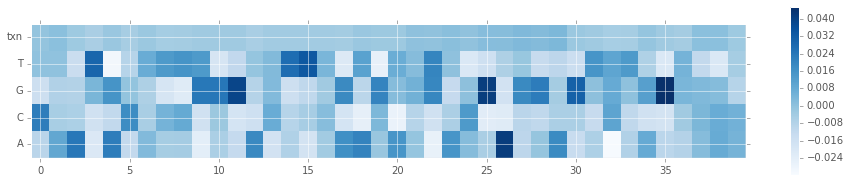

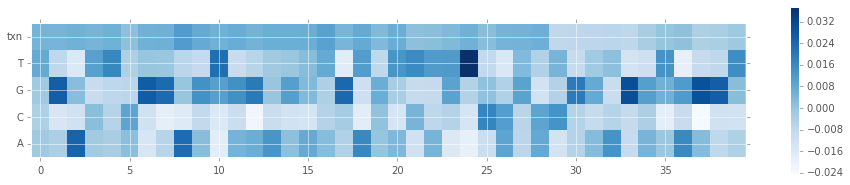

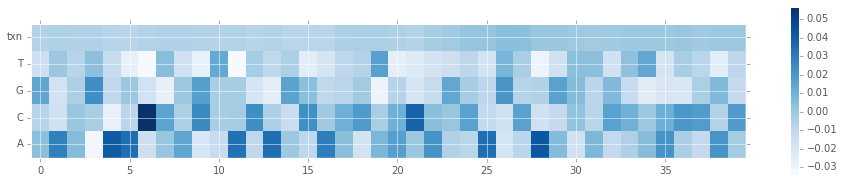

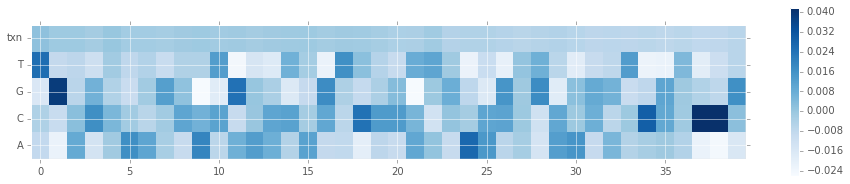

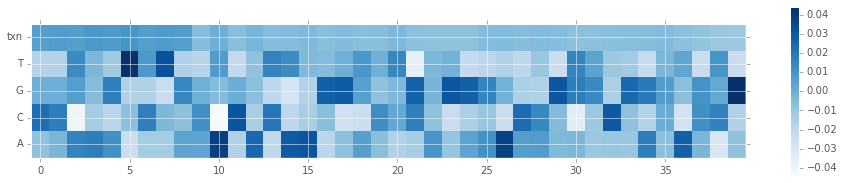

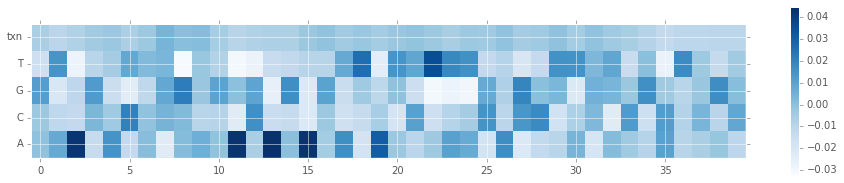

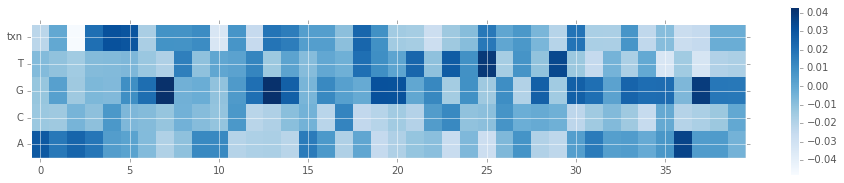

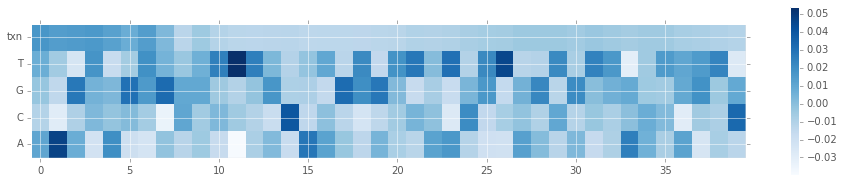

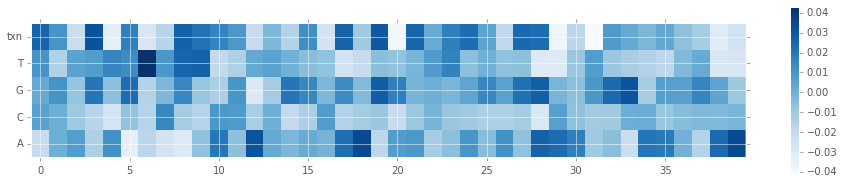

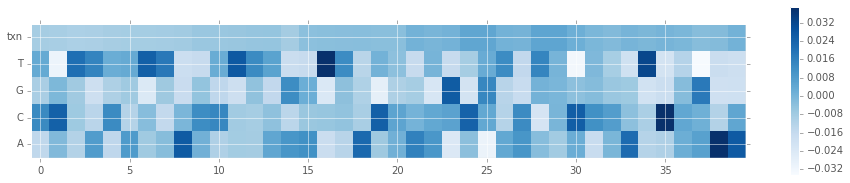

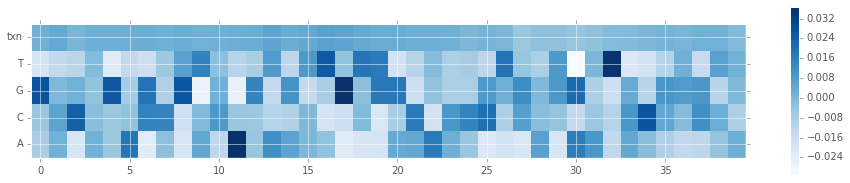

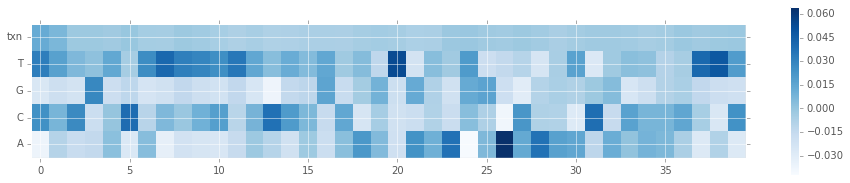

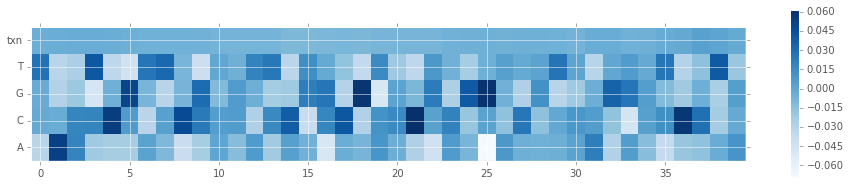

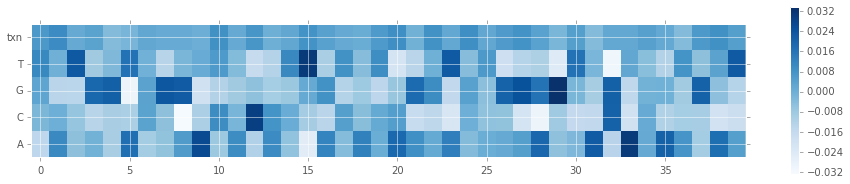

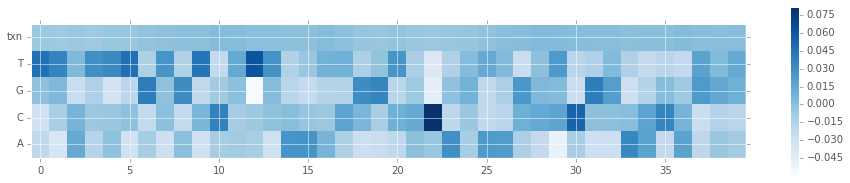

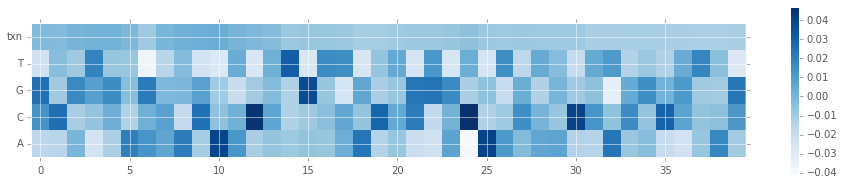

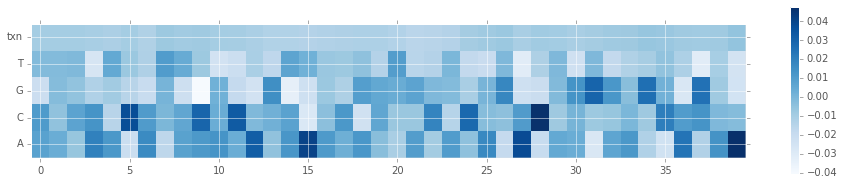

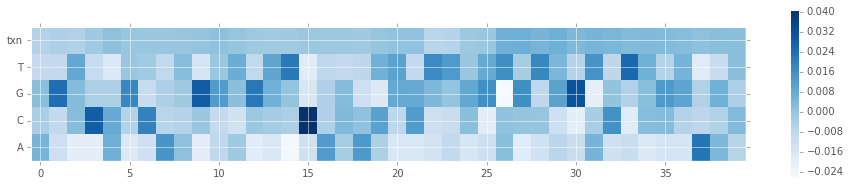

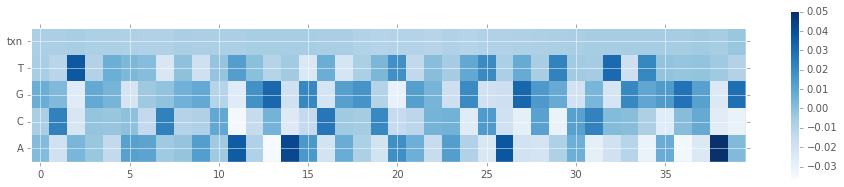

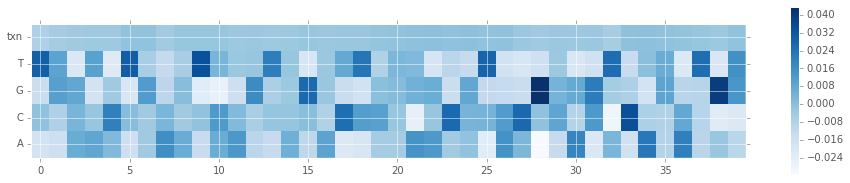

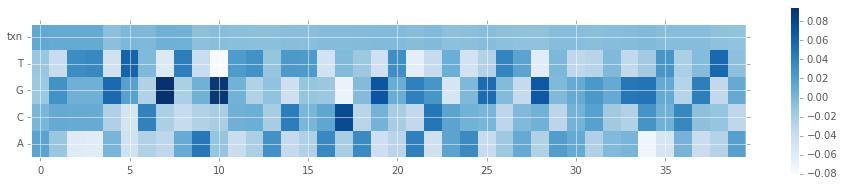

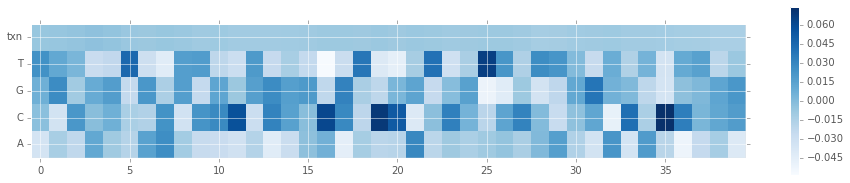

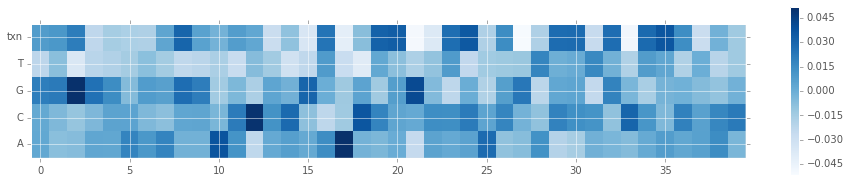

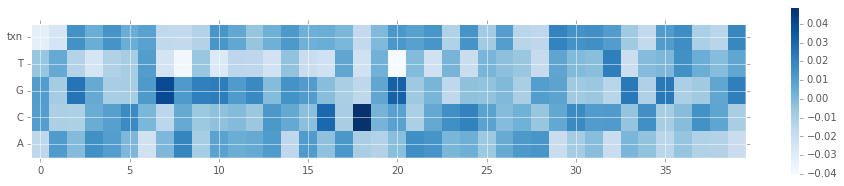

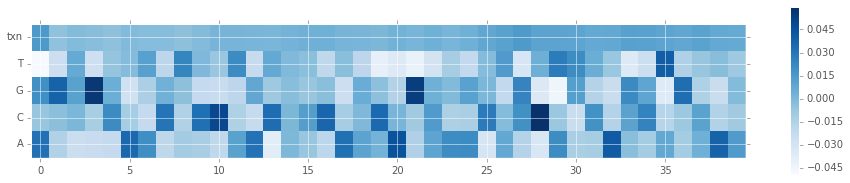

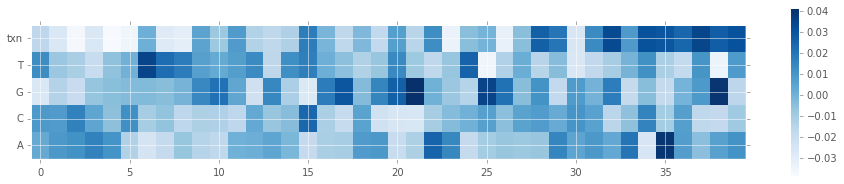

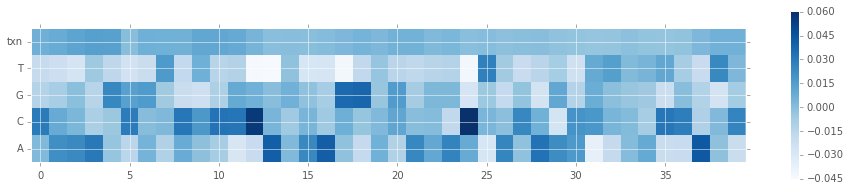

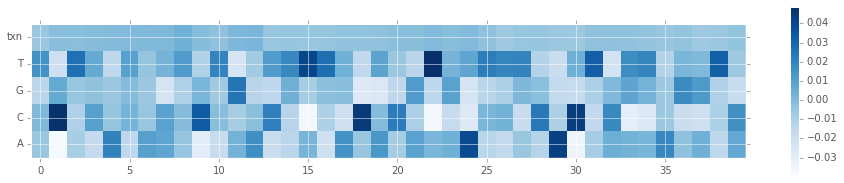

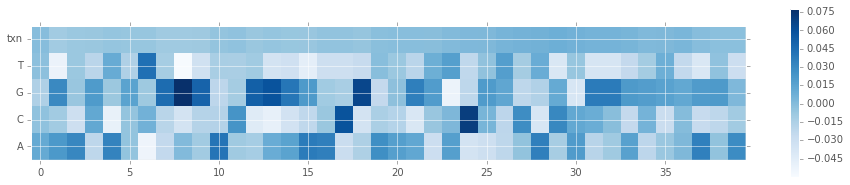

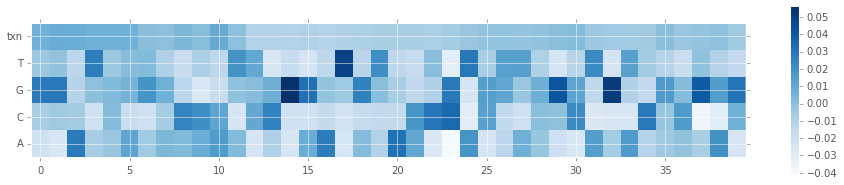

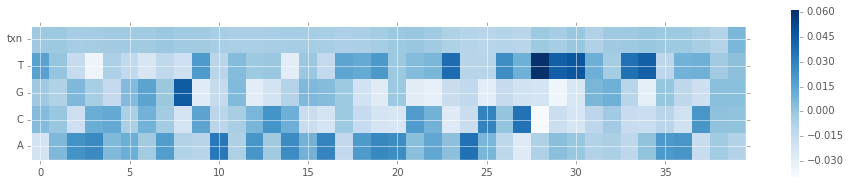

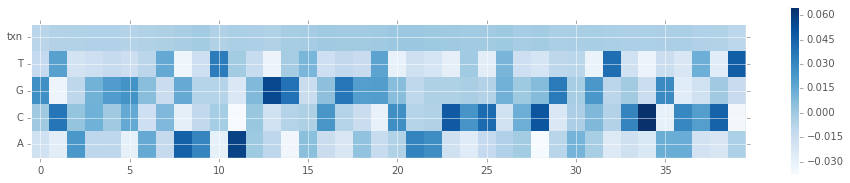

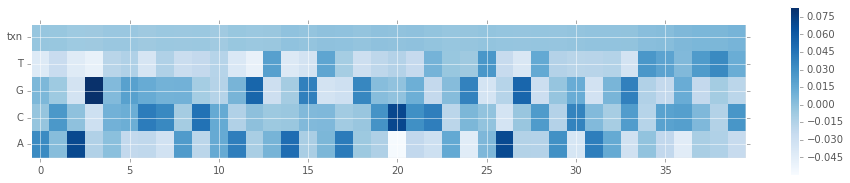

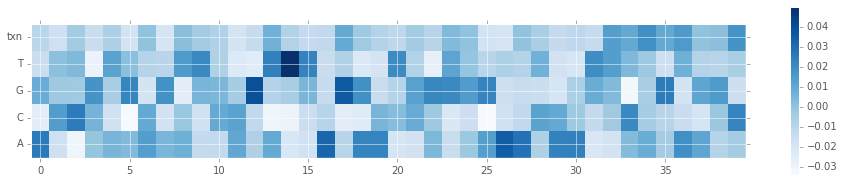

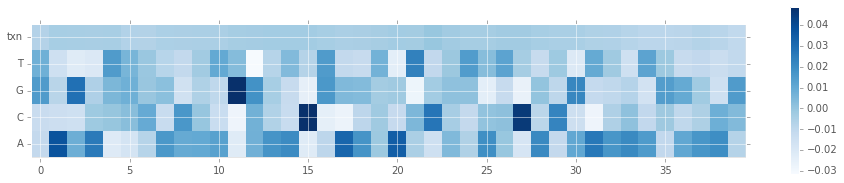

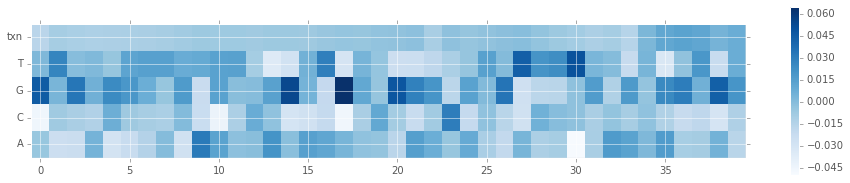

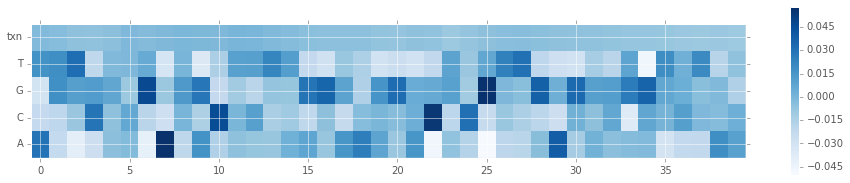

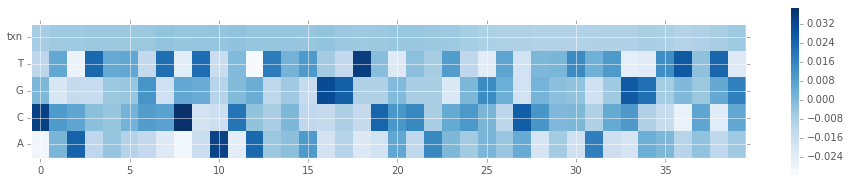

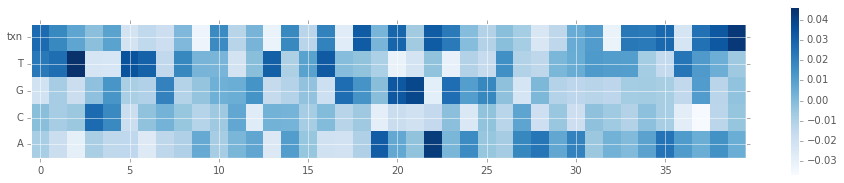

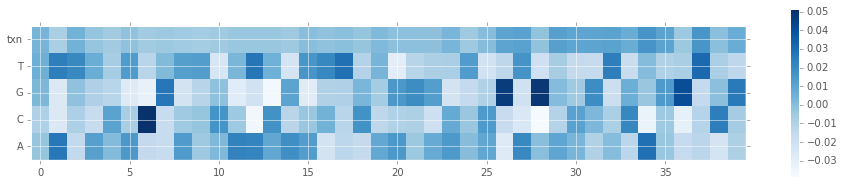

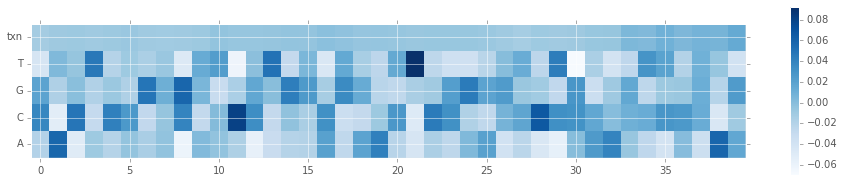

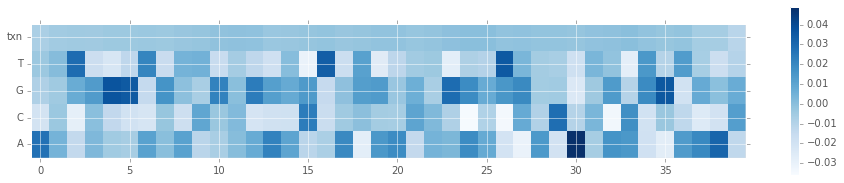

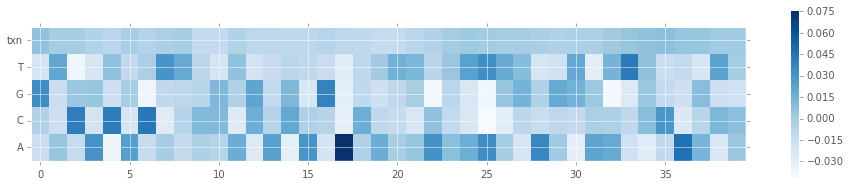

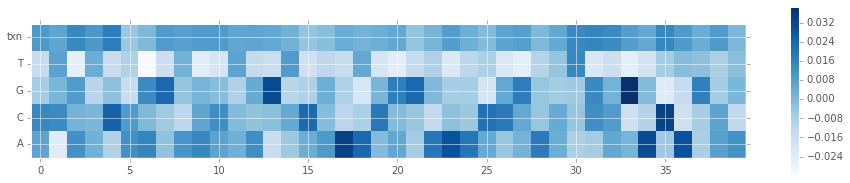

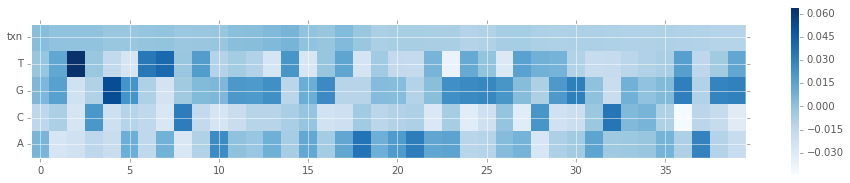

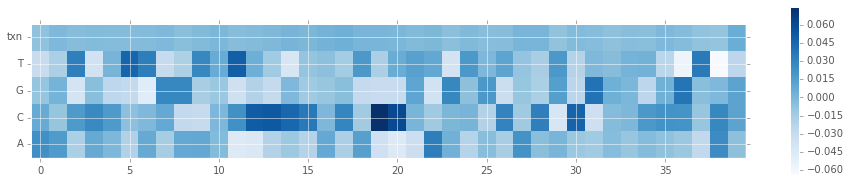

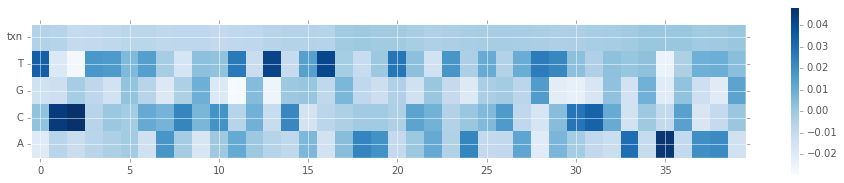

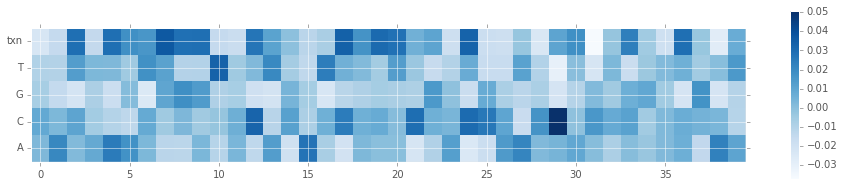

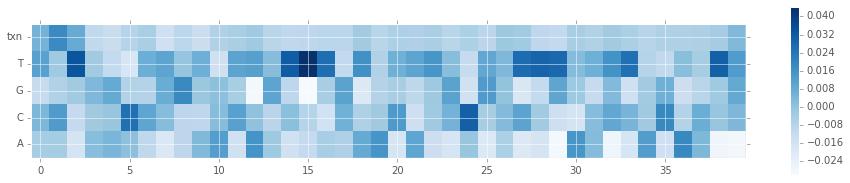

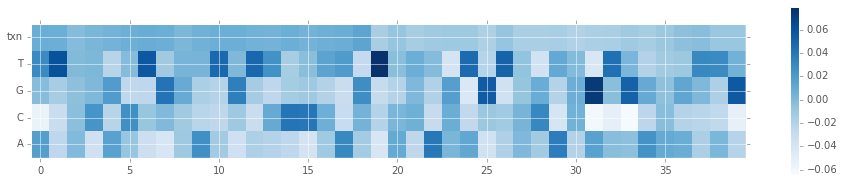

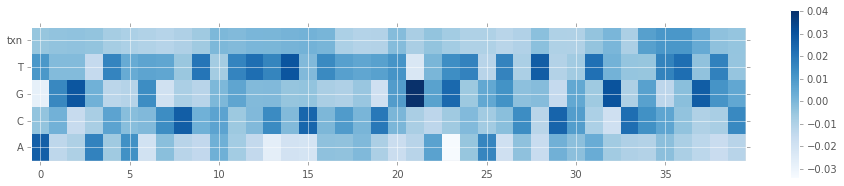

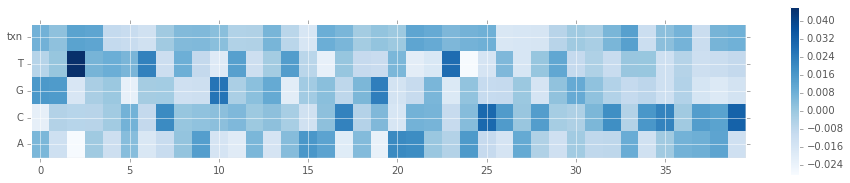

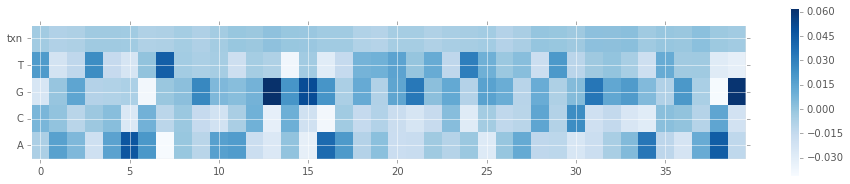

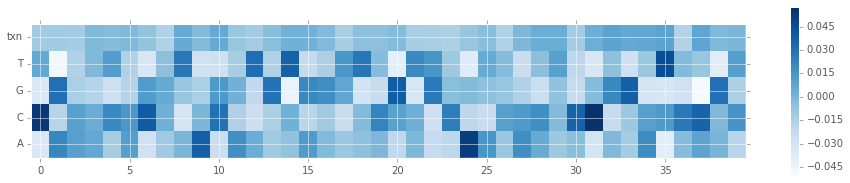

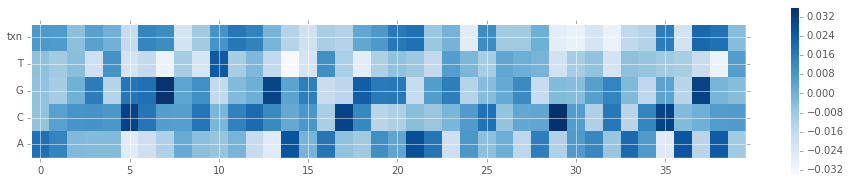

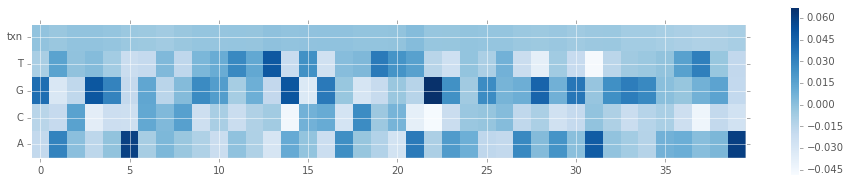

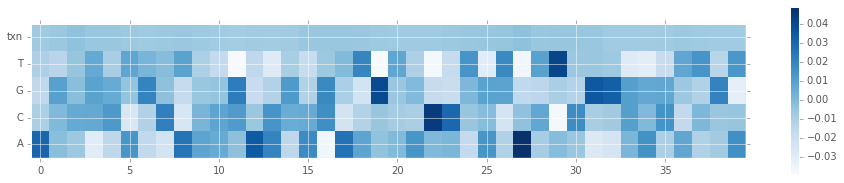

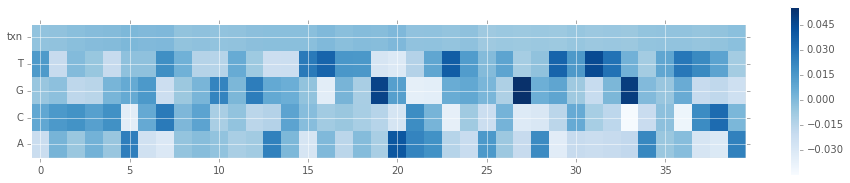

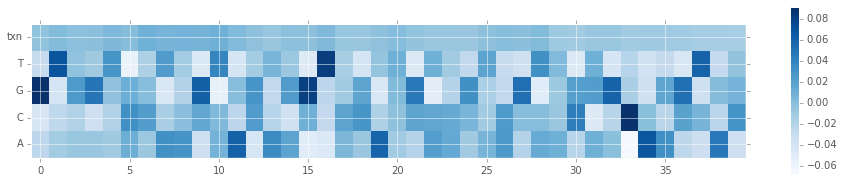

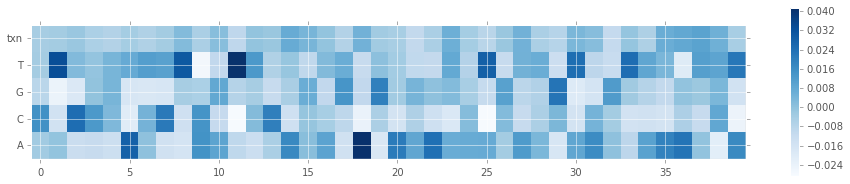

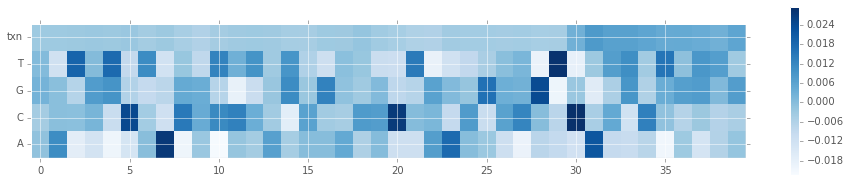

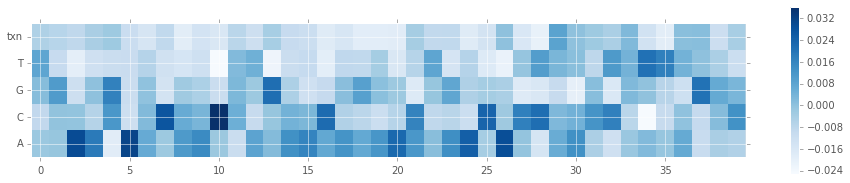

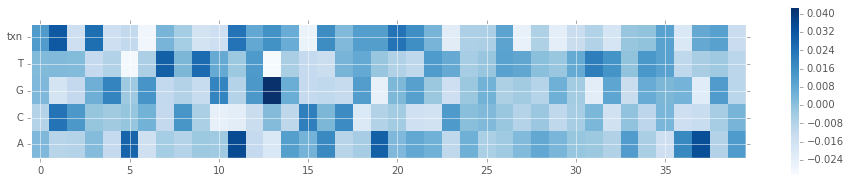

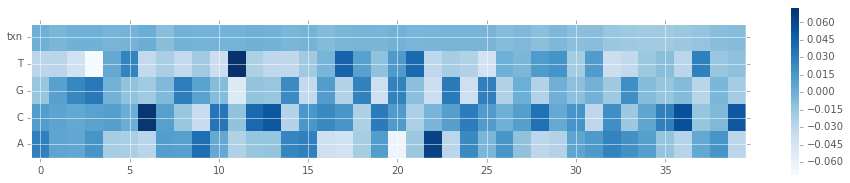

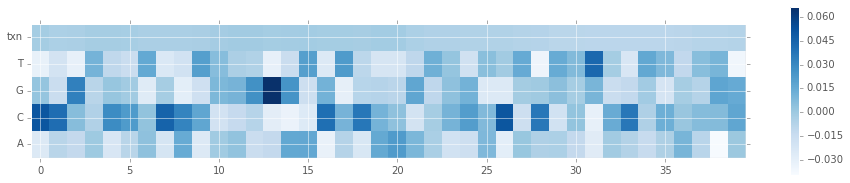

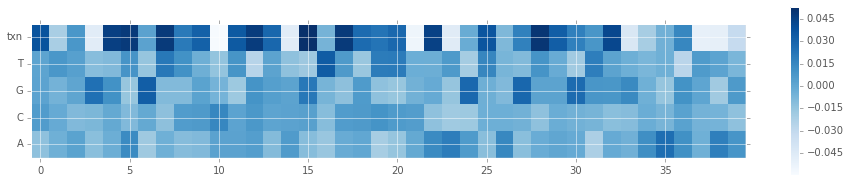

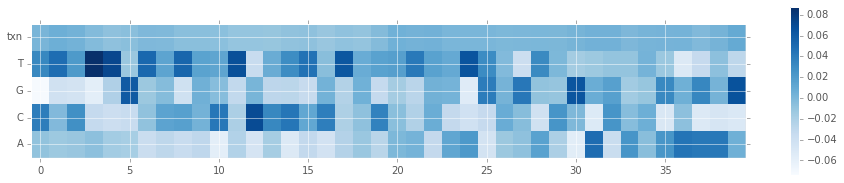

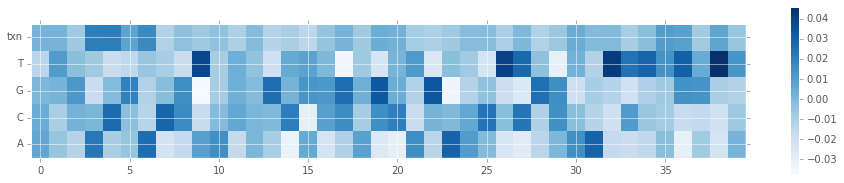

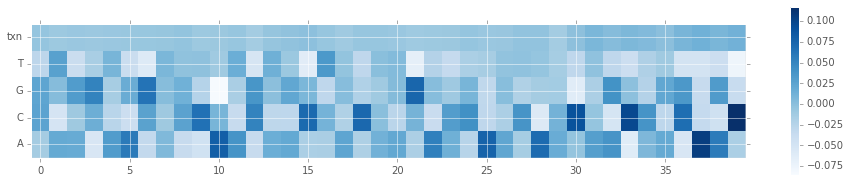

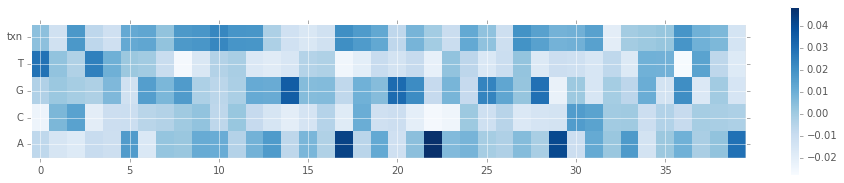

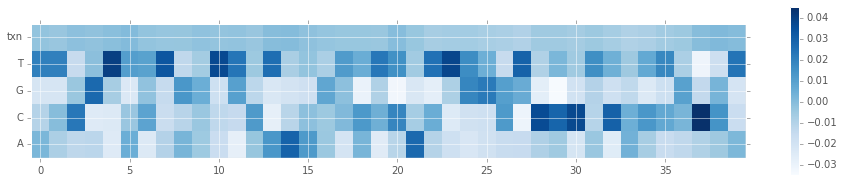

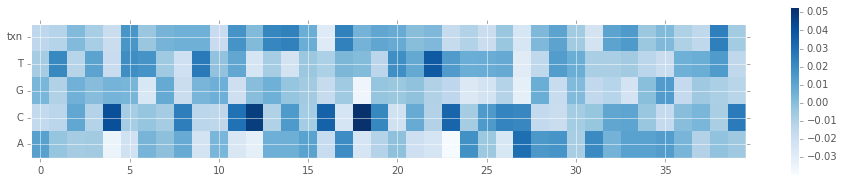

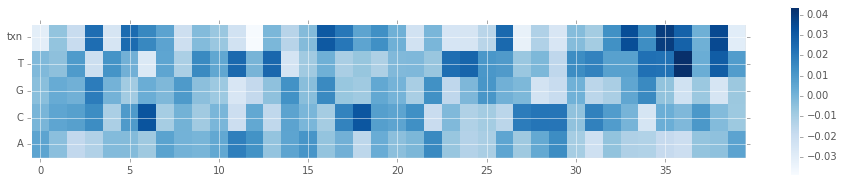

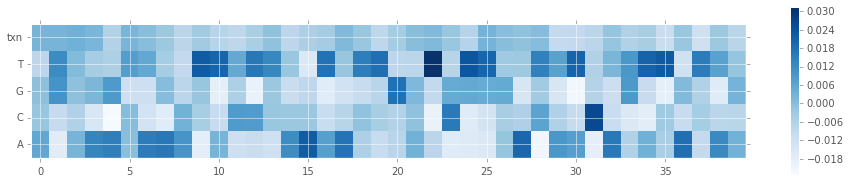

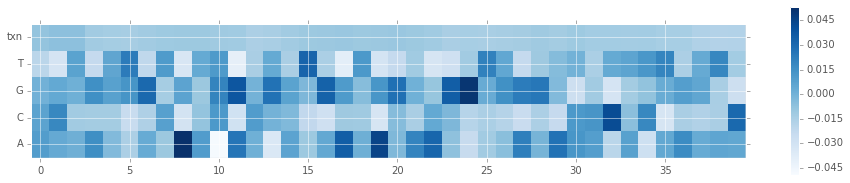

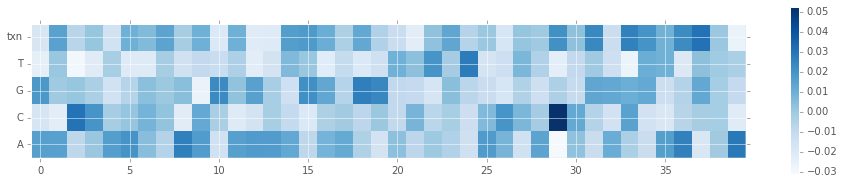

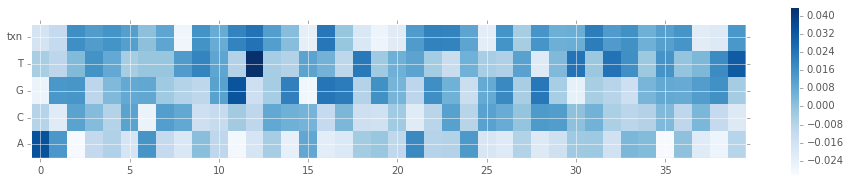

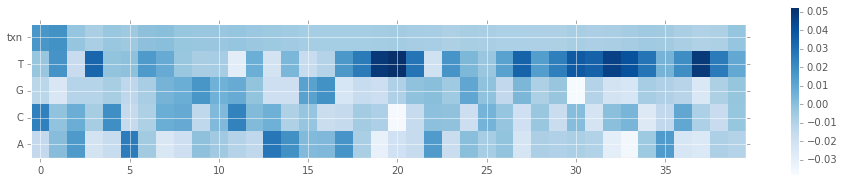

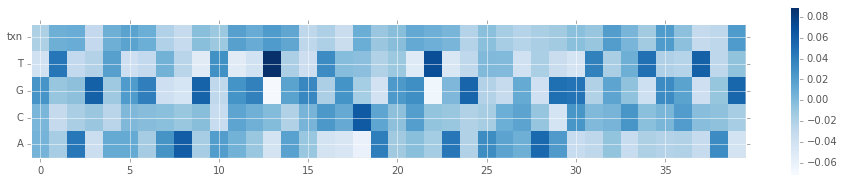

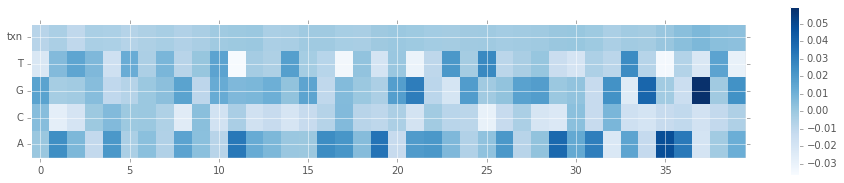

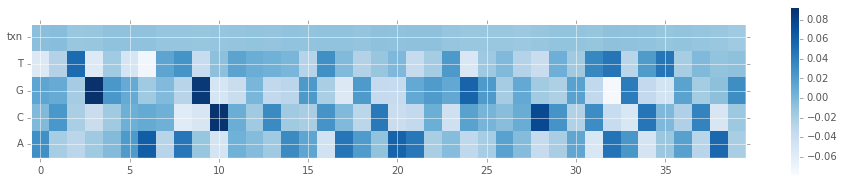

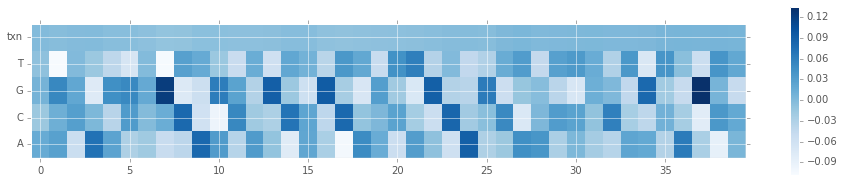

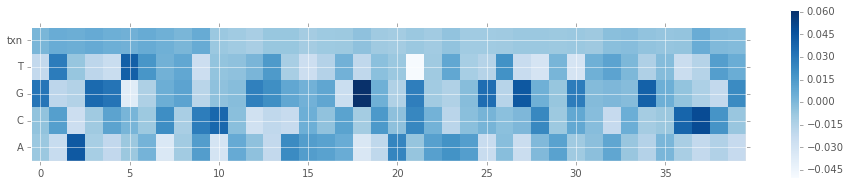

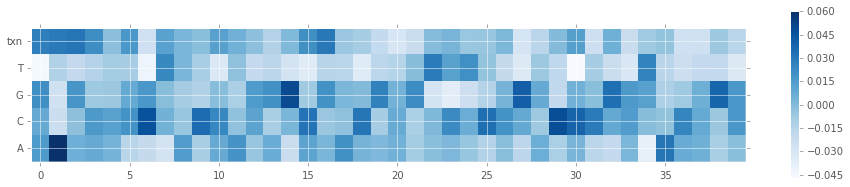

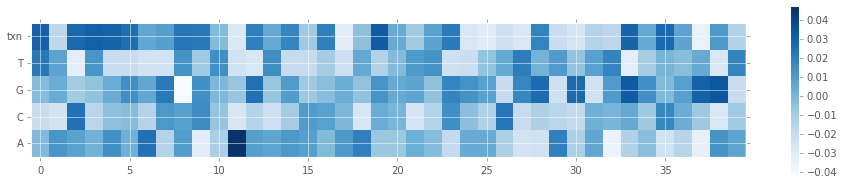

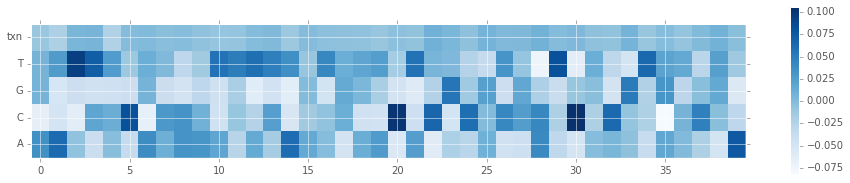

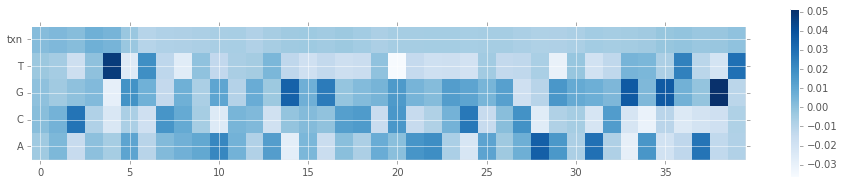

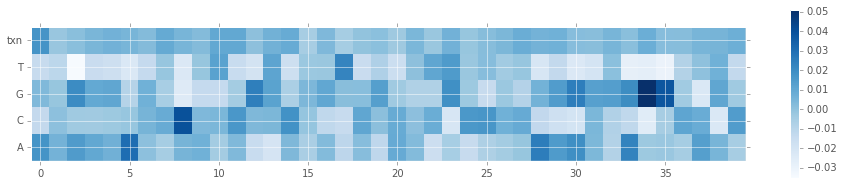

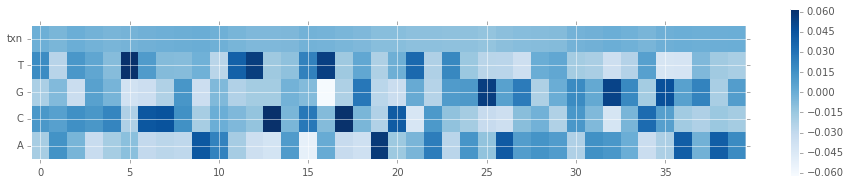

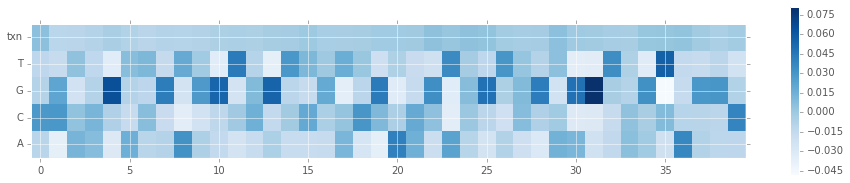

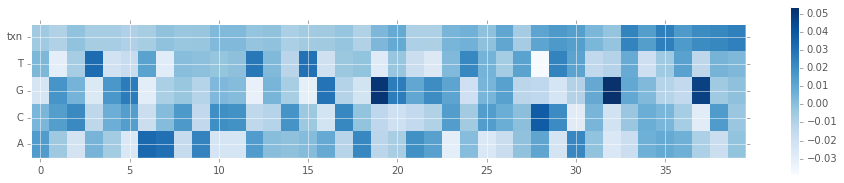

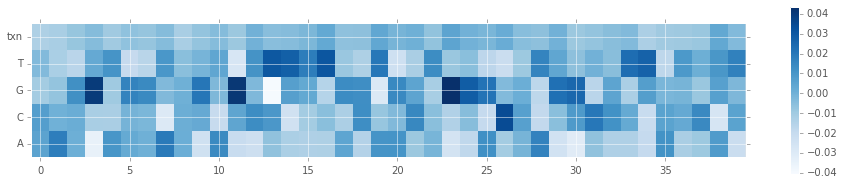

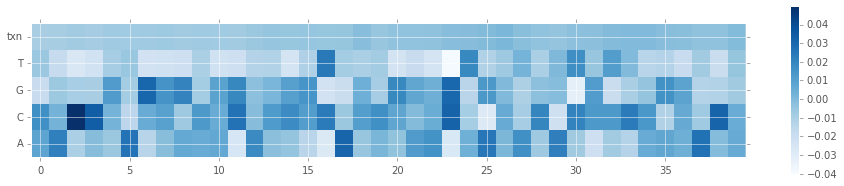

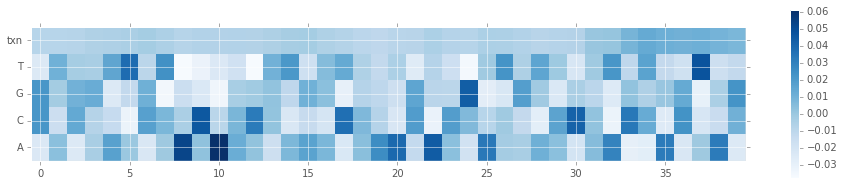

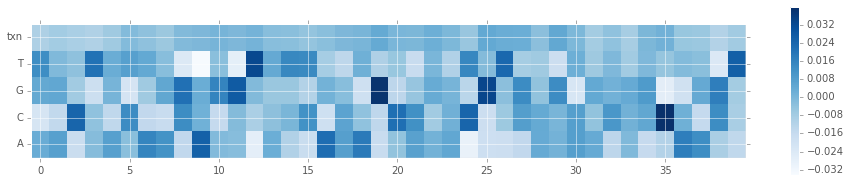

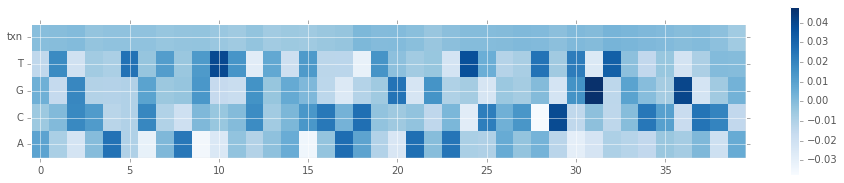

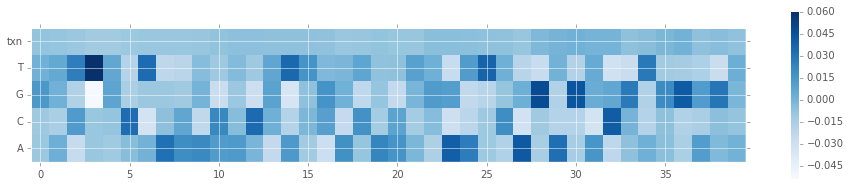

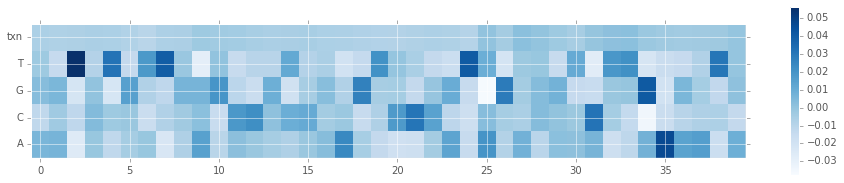

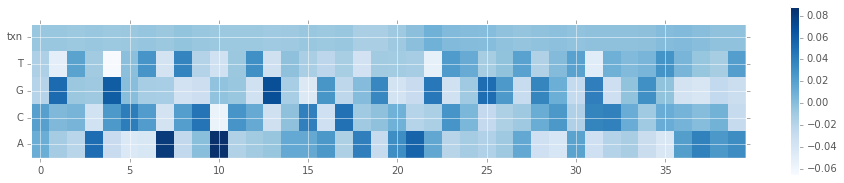

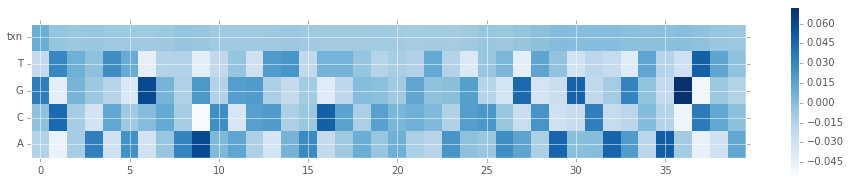

In [38]:
for w, in weigths:
    plt.figure(figsize=(16,3))
    plt.imshow(w.T,interpolation='none',aspect=1.5,cmap='Blues')
    plt.colorbar()
    dump=plt.yticks([0,1,2,3,4],['txn','T','G','C','A'])